### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
from pprint import pprint
sns.set()

# Natural Language Toolkit
import nltk
nltk.download('stopwords')

# A package to process word contractions
from pycontractions import Contractions
import gensim.downloader as api


import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy

# plotting tools
import pyLDAvis
import pyLDAvis.gensim

[nltk_data] Downloading package stopwords to /home/anna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# load the data
df = pd.read_csv('debate_transcripts_v2_2020-02-23.csv',encoding='cp1252')

I'd like to answer the question, who spent the most time talking about each subject during the democratic primary debates.

### Exploring the Data

In [3]:
df.shape

(5333, 5)

In [4]:
# prints top 10 entries
df.head(10)

,debate_name,debate_section,speaker,speech,speaking_time_seconds
0,New Hampshire Democratic Debate Transcript,Part 1,George S.,"Candidates, welcome. Vice President Biden, the...",18.0
1,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Oh, they didn’t miss anything. It’s a long rac...",36.0
2,New Hampshire Democratic Debate Transcript,Part 1,George S.,Why are Senator Sanders and Mayor Buttigieg to...,4.0
3,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Well, you know that with regard to Senator San...",41.0
4,New Hampshire Democratic Debate Transcript,Part 1,George S.,"Senator Sanders, let me give you the chance to...",21.0
5,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,Because Donald Trump lies all the time. It doe...,41.0
6,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,I believe that the way we beat Trump is by hav...,39.0
7,New Hampshire Democratic Debate Transcript,Part 1,George S.,"But Senator, let me follow up there and then w...",12.0
8,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,That’s true. And that’s the disappointment and...,23.0
9,New Hampshire Democratic Debate Transcript,Part 1,George S.,"Before I move on to Mayor Buttigieg, let me ju...",11.0


Here we look for missing entries. Since I'm asking the question, who spent the most time on what topics, it is necessary that speaking_time is filled in.

In [5]:
# now to look for missing entries
df.isna().sum(axis=0)

debate_name                0
debate_section             0
speaker                    0
speech                     0
speaking_time_seconds    513
dtype: int64

There are 513 missing values. Since I want to ask which candidate spent the most time talking about which topics, I cannot use these rows and they should be removed. Now let's take a look at the remaining distribution.

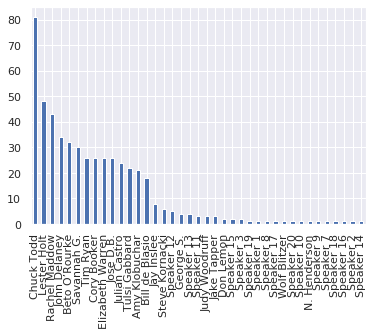

In [6]:
df[df.isna().any(axis=1)]['speaker'].value_counts().plot(kind='bar')

A significant fraction of these entries come from moderators/anchors: Chuck Todd, Lester Holt, Rachel Maddow, etc. Removing these entries should have little effect on the data, except in the cases of Elizabeth Warren and Tulsi Gabbard.

The next question to answer is why don't these entries have speaking time.


In [7]:
# selects data frame where NaN speaking time and chuck todd is the speaker .speaker.isin(['Chuck Todd'])
df[df.isna().any(axis=1)]['speech']

153     We have much more today coming up, but we have...
322     Candidates. Thank you. Thanks for a great deba...
669     Candidates, thank you very, very much. That co...
826     We’re going to take a short break and we will be…
1030    We are going to take a very short break. That ...
                              ...                        
4807    But I got my chance. It was a 50 dollar a seme...
4808    We would like to thank all of the candidates t...
4809    We certainly hope you will join us then. But f...
5075                      Mayor Buttigieg, your thoughts.
5332    For now, for all of us at NBC News, I’m Lester...
Name: speech, Length: 513, dtype: object

It appears that a significant portion of these entries are due to commercial breaks and are safe to remove.

In [8]:
# drop the NaN entries
df.dropna(inplace=True)

In [9]:
df.isna().sum() # all clear!

debate_name              0
debate_section           0
speaker                  0
speech                   0
speaking_time_seconds    0
dtype: int64

The next question is what do we do with the moderator questions?
For simplicity, I'm going to throw out everyone I don't care about. Here, I'm going to focus on candidates who made it to the first primary vote:

Bernie Sanders, Elizabeth Warren, Amy Klobuchar,Pete Buttigieg, 
Joe Biden, Tulsi Gabbard, Michael Bloomberg

In [10]:
print(sorted(set(df['speaker'])))

['A. Cooper', 'Abby Phillips', 'Adam Sexton', 'Amna Nawaz', 'Amy Klobuchar', 'Amy Walter', 'Anderson Cooper', 'Andrea Mitchell', 'Andrew Yang', 'Announcer', 'Ashley Parker', 'Audience', 'B. Pfannenstiel', 'Bennett', 'Bernie Sanders', 'Beto O’Rourke', 'Bill de Blasio', 'Brianne P.', 'Chuck Todd', 'Cory Booker', 'Crowd', 'Dana Bash', 'David Muir', 'Devin Dwyer', 'Diana', 'Don Lemon', 'Elizabeth Warren', 'Eric Stalwell', 'Eric Swalwell', 'Erin Burnett', 'Female', 'George S.', 'Hallie Jackson', 'Helen', 'J. Hickenlooper', 'Jake Tapper', 'Jay Inslee', 'Joe Biden', 'John Delaney', 'John H.', 'John Hickenloop', 'John King', 'Jon Ralston', 'Jorge Ramos', 'Jose D.B.', 'Judy Woodruff', 'Julian Castro', 'Kamala Harris', 'Kirseten Gillibrand', 'Kirsten Gillibrand', 'Kristen Welker', 'Lester Holt', 'Linsey Davis', 'Male', 'Marc Lacey', 'Marianne Williamson', 'Michael Bennet', 'Michael Bloomberg', 'Moderator', 'Moderator 1', 'Moderator 2', 'Moderator 4', 'Monica Hernandez', 'N. Henderson', 'Pete But

In [22]:
# select for the people we want
speakers = ['Amy Klobuchar','Bernie Sanders', 'Elizabeth Warren','Joe Biden','Michael Bloomberg','Pete Buttigieg','Tulsi Gabbard']

In [23]:
df = df[df.speaker.isin(speakers)] # only keep the relevant candidates

In [13]:
df.reset_index(inplace=True,drop=True) # resets the index now that we've dropped columns

In [14]:
df.head()

,debate_name,debate_section,speaker,speech,speaking_time_seconds
0,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Oh, they didn’t miss anything. It’s a long rac...",36.0
1,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Well, you know that with regard to Senator San...",41.0
2,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,Because Donald Trump lies all the time. It doe...,41.0
3,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,I believe that the way we beat Trump is by hav...,39.0
4,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,That’s true. And that’s the disappointment and...,23.0


Now that we have our chosen candidates, I want to ensure that I use data from candidates who have enough time to actually say something. Candidates can and do get interupted by both moderators and other candidates.

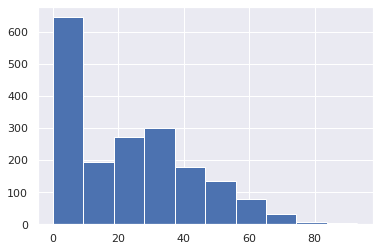

In [15]:
df['speaking_time_seconds'].hist()

There are a lot of entries with < 10 seconds. Now let's look at those entries to see when topics start appearing. I start with a lower threshold of 2 seconds, and an upper threshold of 5 seconds. I realized that many of these entries ended with a dash '-', indicating that the speaker got cutoff or interrupted.

In [16]:
selector = (df['speaking_time_seconds']<5) & (df['speaking_time_seconds']>2)
df[selector]['speech'][df[selector]['speech'].str.endswith("-")]

717                             I want to give a reality-
773     What we owe to those survivors is to actually ...
783     We’ve got to attack the corruption and repeal ...
793           That is why we need a political revolution-
805     I’d like to ask our other candidates this ques...
812        … why it is that we have had laws on the book-
850     You’ve got to take on the greed and the profit...
867     … had to fight against people in his own admin...
1177    And it’s not nearly enough. [crosstalk 00:16:1...
1215    Donald Trump wants to use these people as poli...
1230                 And when 90% of Americans to happen-
1282    And I truly believe that if we’re going to mov...
1323    Four little girls in Birmingham, Alabama lost ...
1474    I reject the premise that there’s only one or ...
1476    We need a political revolution. People have go...
1486    If the government wants to do that, if people ...
1532                        That’s just not true. People-
1599    It jus

Exploring this data, we can see a good example of a speaker getting interrupted, Pete Buttigieg. The indicies are 773-775, and it is just him talking while getting interrupted. The person who interrupted him got removed by dropping the NaN values.

The key to linking statements should be if the same speaker is speaking in adjacent indicies (or maybe) every other, and the previous statement ends with '-' and the next statement starts with '...', stitch them together.

In [17]:
print(df.loc[773]['speech'])
print(df.loc[774]['speech'])
print(df.loc[775]['speech'])

What we owe to those survivors is to actually deliver a solution. I’m glad you offered up-
… that analogy to healthcare because this is really important. We are at the cusp of building a new American majority, to actually do things that congressmen and senators have been talking about with almost no impact for my entire-
… adult life. No, this is really important, okay? On guns, we are this close to an assault weapons ban. That would be huge.


Define a merge function. Which would merge statements like above.

In [18]:
def merge_speaking(df,indicies):
    '''
    df: a copy of the supplied dataframe 
    indicies: a list of that want to add together, accesible by iloc
    '''
    clean_strs = ''
    total_time = 0
    
    for i in indicies:

        # clean the strings
        tmp = (re.sub('-$','',df.loc[i]['speech']))
        tmp = re.sub('^\u2026','',tmp)
        total_time = total_time + df.loc[i]['speaking_time_seconds']
        clean_strs = clean_strs + tmp
    
    # drop the extra rows
    df = df.drop(indicies[1:])
    df.loc[indicies[0],'speech'] = clean_strs
    df.loc[indicies[0],'speaking_time_seconds'] = total_time
    return df
        

In [20]:
# Test case
merge = [773,774,775]
p = merge_speaking(df,merge)
print(p.loc[773]['speech']) #it worked!

What we owe to those survivors is to actually deliver a solution. I’m glad you offered up that analogy to healthcare because this is really important. We are at the cusp of building a new American majority, to actually do things that congressmen and senators have been talking about with almost no impact for my entire adult life. No, this is really important, okay? On guns, we are this close to an assault weapons ban. That would be huge.


Define a function to identify which indicies need to be merged.

In [21]:
def get_merge_indicies(df,speaker):
    indices = []
    tmp = []
    interrupted = False
    for i,row in df[df['speaker']==speaker].iterrows():
        if (not interrupted) and (row['speech'].endswith('-')):
            interrupted = True
            tmp.append(i)

        elif interrupted and row['speech'].startswith('\u2026'):
            tmp.append(i)
            if not row['speech'].endswith('-'):
                indices.append(tmp)
                tmp = []
                interrupted = False
        else:
            interrupted = False
            if len(tmp) > 0:
                if len(tmp) > 1:
                    indices.append(tmp)
                tmp = []
    
    return indices

In [27]:
# get the indices which need appending
all_indices = []
for speaker in speakers:
    speaker_indices = get_merge_indicies(df,speaker)
    all_indices.append(speaker_indices)

In [28]:
for idxs in all_indices:
    for merge in idxs:
        df = merge_speaking(df,merge)
        #print(p.loc[merge[0]]['speech'])

Let's look at whether anything of substance is said in less than one second now that the interrupting segments are merged.

In [29]:
selector = df['speaking_time_seconds'] < 1
df[selector]['speech']

27                                 70 is the new 50.
30                            George, George, can I…
53                                    Let’s do that.
66                                              Yes.
95                          Let’s get that straight.
                            ...                     
1758                                  May I respond?
1766    Can I respond to the Vice President, please?
1789                                           Just-
1797                             You know what Pete?
1824                                      Thank you.
Name: speech, Length: 113, dtype: object

Looks like anything left are short, cute sentences that don't have much content. These can be safely removed as they aren't long enough for topics.

In [30]:
df = df[~selector]

Now, two seconds...

In [34]:
selector = (df['speaking_time_seconds'] <2)
df[selector]['speech']

5                                                I’m not.
41                   I wasn’t able to hear that question.
50                                           There we go.
93           We ought to be able to sue the gun industry.
113                     I don’t think that’s quite right.
                              ...                        
1811                                   Play by the rules.
1813                   Not necessarily. Not till there’s-
1814                                Let the process work.
1817                                                 Yes.
1818    … who has the most votes should become the nom...
Name: speech, Length: 137, dtype: object

Seems like it's okay to remove these too. I see one passage talking about election policy, but I'm looking for larger political topics.

In [35]:
df = df[~selector]

In [36]:
df.reset_index(inplace=True,drop=True) # resets the index now that we've dropped columns

In [37]:
df

,debate_name,debate_section,speaker,speech,speaking_time_seconds
0,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Oh, they didn’t miss anything. It’s a long rac...",36.0
1,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Well, you know that with regard to Senator San...",41.0
2,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,Because Donald Trump lies all the time. It doe...,41.0
3,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,I believe that the way we beat Trump is by hav...,39.0
4,New Hampshire Democratic Debate Transcript,Part 1,Bernie Sanders,That’s true. And that’s the disappointment and...,23.0
...,...,...,...,...,...
1520,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Joe Biden,"Lastly, I think it’s important that on day one...",13.0
1521,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Joe Biden,"Had, in fact, that immigration bill passed the...",5.0
1522,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Bernie Sanders,"Unfortunately Rulac, among other groups, Latin...",17.0
1523,"Democratic Debate Transcript: Las Vegas, Nevad...",Part 2,Bernie Sanders,"But where we don’t agree, I think, is why we a...",24.0


In [38]:
selector = df['speaking_time_seconds']<3
df[selector]['speech'].iloc[10]

'… getting rid of the oil giveaways …'

I'm starting to see words like 'oil' and 'immigration'. These statements need to be kept.

# FINISH THIS
Topic Modelling is a technique to extract hidden topics from a large body of text. The challenge presents itself with how to extract a good number of topics. Ones which are distinct and meaningful.

There are a couple topic modelling algorithms, but I will focus this work on Latent Dirichlet Allocation (LDA).

LDA - Latent Dirichlet Allocation. This interprets a document as a collection of topics at some proportion. The topics are considered a collection of dominant keywords at some proportion.

### Preprocessing the Data

The preprocessing of data involves:

#### Tokenization: 
Sentences are split into individual lists of words.

#### Removeal of Stopwords:
Stopwords are words which have no meaning by themselves. They are words like 'of', 'is', 'the', etc. There is no common database for all stopwords. When testing topic modelling, stopwords can also include words which yield low quality topics.

#### Lemmatization:
Converts words into their root form, or lemma. It converts the words 'runs' and 'running' to their lemma, 'run'. It also handles tense. Words like 'went', 'goes', and 'gone' will be converted to their lemma, 'go'.

#### Bigrams and Trigrams:
Bigrams and trigrams. These are series of two or three words which appear next to each other.

#### Choosing Stopwords

I am using a list provided by the natural language processing toolkit (nltk).

Extended stop words are words I've chosen to remove, in addition to the standard dictionary I'm using. These words are chosen in order to create higher quality topics.

In [44]:
# stopwords filter out words which make the topics have low quality
from nltk.corpus import stopwords

In [303]:
# load the stopwords and add some of my own
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','question','time','things','thing','com'])

#### Tokenization
Here I need to break up the setences into a list of individual words. This means I need to expand contractions, remove puncuation, and remove weird characters in the text.

In [304]:
data = df.speech.tolist()
# remove ellipses
data = [re.sub('\u2026', '', response) for response in data]   

Next we need to remove things like '[crosstalk ##:##:##]' or '[inaudible ##:##:##]'

In [305]:
data = [re.sub('.crosstalk [0-9][0-9]:[0-9][0-9]:[0-9][0-9]..','',response) for response in data]
data = [re.sub('.inaudible [0-9][0-9]:[0-9][0-9]:[0-9][0-9]..','',response) for response in data]

In [306]:
# cp1252 to unicode encoding for the apostrophe
data = [re.sub("\u2019","\u0027",response) for response in data]

##### Expand contractions

Words like 'don't' will be converted into its uncontracted form: 'do' and 'not'

Here I am using a package called pycontractions.

In [307]:
# model for contractions function
# not from disk, takes awhile to load
model = api.load("word2vec-google-news-300")

In [308]:
cont = Contractions(kv_model=model)

In [309]:
# prevents loading on first expand_texts call
cont.load_models()

In [310]:
# expand contractions, takes awhile
data = list(cont.expand_texts(data,precise=True))

#### Tokenize

In [311]:
def tokenize(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [312]:
token_sentences = list(tokenize(data))

#### Building Bigrams and Trigrams

In [313]:
bigram = gensim.models.Phrases(token_sentences, min_count=5,threshold=100)
trigram = gensim.models.Phrases(bigram[token_sentences],threshold=100)

In [314]:
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [315]:
# necessary functions -- borrowed functions

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts,allowed_postags=['NOUN', 'ADJ', 'PROPN']):
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out  

In [316]:
# remove stopwords
nostops = remove_stopwords(token_sentences)

In [317]:
# make bigrams and trigrams
bigrams = make_bigrams(nostops)
trigrams = make_trigrams(nostops)

In [318]:
# loads spaCy model by name
nlp = spacy.load('en', disable=['parser','ner'])

Here I use spaCy package for lemmatization. I also remove words which are not nouns, adjectives, and pronouns.

In [319]:
# lemmatize
lemmatized = lemmatization(trigrams)

In [320]:
# Create Dictionary
id2word = corpora.Dictionary(lemmatized)

# Create Corpus
texts = lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

# mapping (word_id, word_frequency)

In [321]:
id2word[0] # dictionary usage

'bernie'

### Train the Model

Training the LDA model. The model parameters were tuned based on a balance between maximizing the coherence, and eyeballing topics such that they make sense.

In [326]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6,
                                           random_state=200,
                                           update_every=1,
                                           chunksize=100,
                                           passes=15,
                                           eta = 1,
                                           alpha='auto',
                                           per_word_topics=True)

In [327]:
# print the topics and 10 most associated words
pprint(lda_model.print_topics())

[(0,
  '0.012*"world" + 0.008*"war" + 0.006*"china" + 0.005*"afghanistan" + '
  '0.005*"agreement" + 0.004*"iraq" + 0.004*"military" + 0.004*"troop" + '
  '0.003*"ally" + 0.003*"energy"'),
 (1,
  '0.007*"nra" + 0.004*"delegate" + 0.002*"hide" + 0.002*"corridor" + '
  '0.002*"gun" + 0.002*"loophole" + 0.001*"ban" + 0.001*"weapon" + '
  '0.001*"universal_background_check" + 0.001*"sale"'),
 (2,
  '0.002*"setback" + 0.001*"professional" + 0.001*"advancement" + '
  '0.001*"unclear" + 0.001*"greeting" + 0.001*"forgetfulness" + '
  '0.001*"momentary" + 0.001*"lopez" + 0.001*"obrador" + 0.001*"knesset"'),
 (3,
  '0.016*"healthcare" + 0.013*"plan" + 0.011*"year" + 0.010*"tax" + '
  '0.010*"medicare" + 0.009*"cost" + 0.007*"people" + 0.007*"family" + '
  '0.007*"taxis" + 0.006*"education"'),
 (4,
  '0.002*"court" + 0.001*"supreme_court" + 0.001*"justice" + '
  '0.001*"litmus_test" + 0.001*"shelter" + 0.001*"body" + 0.001*"hawaii" + '
  '0.001*"judge" + 0.001*"roe_wade" + 0.001*"reproductive"'),

##### Topic 0: War
world, war, chine, afghanistan, agreement, iraq, military, troop, ally, energy

##### Topic 1: Guns
nra, delegate, hide,corridor, gun, loophole, ban, weapon, universal background check, sale

##### Topic 2: Common words used when describing an unaccomplished goal
setback, professional, advancement, unclear, greeting, forgetfulness, momentary, lopez, obrador, knesset

##### Topic 3: Healthcare
healthcare, plan, year, tax, medicare, cost, people, family taxis, education

##### Topic 4: Judicial System
court, supreme court, justice, litmus test, shelter, body, hawaii judge, roe wade, reproductive

##### Topic 5: America/ The American people
people, country, president, way, american, america, right, fact, year job

### Metrics
Here I compute two metrics, perplexity and coherence, in order to get an idea of how good the topic model is.

Perplexity is a measure for how surprised a model is of new data. It is defined as $2^{H(\tilde{p},q)}$, where $H(\tilde{p},q)$ is the cross-entropy between, our sampled distribution, $\tilde{p}$, and our model, $q$. Using perplexity as the sole metric does not necessarily lead to human-interprettable results.

Topic coherence attempts to incorporate human judgement. It measures the degree of semantic similarity between words in a topic. In other words, 'how much of word A has to do with word B?'.

In [328]:
# Compute Perplexity
# Function outputs cross entropy and perplexity is written to file
print('Perplexity: ', lda_model.log_perplexity(corpus))

Perplexity:  -7.3831929024513165


In [329]:
# Compute Coherence
coherence_model = CoherenceModel(model=lda_model, texts=lemmatized, dictionary=id2word,coherence='c_v')
coherence_lda = coherence_model.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.36515297329357027


#### Visualization

This is a visualization tool for LDA. It displays a two-dimensional principle component analysis (PCA) plot of the topics. I used this to prevent topics from having severe overlap. This method has its limitations as projecting a high dimensional space onto two dimensions can make separated topics appear to heavily over lap.

This tool pops open a new interactive window and does not display in this notebook.

In [97]:
pyLDAvis.enable_notebook()

In [98]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

In [99]:
viz = pyLDAvis.show(vis)


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8891/    [Ctrl-C to exit]


127.0.0.1 - - [14/Mar/2020 19:45:45] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [14/Mar/2020 19:45:45] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [14/Mar/2020 19:45:45] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [14/Mar/2020 19:45:45] code 404, message Not Found
127.0.0.1 - - [14/Mar/2020 19:45:45] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [14/Mar/2020 19:45:45] "GET /LDAvis.js HTTP/1.1" 200 -



stopping Server...


Now we turn back to evaluating speakers. What speaker talks the most about which topic? To determine this, I will use the ldamodel to find a probability distribution for each response. I will label the document by a single topic, the one which has the highest probability. This, of course, is a simplified view of what is going on, as each response can contain one or more of these topics. 

In [343]:
# Define a function to get the associated topic probabilities
def get_doc_topics(bow,lda_model):
    '''
    Takes doc text in bag-of-words form and a trained lda_model
    to return the probabilities that each document belongs to a
    specific topic.
    '''
    doc_topics = []
    for doc in bow:
        doc_topics.append(np.array(lda_model.get_document_topics(doc)))
    return doc_topics

In [344]:
doc_topics = get_doc_topics(corpus,lda_model)

In [345]:
highest_prob = []
for doc in doc_topics:    
    highest_prob.append(doc[np.argmax(doc[:,1])][0])

In [333]:
print(doc_topics[:5])
highest_prob[:5]

[array([[5.        , 0.99036133]]), array([[5.        , 0.99347234]]), array([[5.      , 0.987692]]), array([[5.        , 0.99147534]]), array([[5.        , 0.98891813]])]


[5.0, 5.0, 5.0, 5.0, 5.0]

In [334]:
df['Topic'] = highest_prob

/home/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [335]:
# creating sub dataframes
biden = df[df['speaker'] == 'Joe Biden']
sanders = df[df['speaker'] == 'Bernie Sanders']
klobuchar = df[df['speaker'] == 'Amy Klobuchar']
warren = df[df['speaker'] == 'Elizabeth Warren']
buttigieg = df[df['speaker'] == 'Pete Buttigieg']
gabbard = df[df['speaker'] == 'Tulsi Gabbard']
bloomberg = df[df['speaker'] == 'Michael Bloomberg']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa003a8bcd0>]],
      dtype=object)

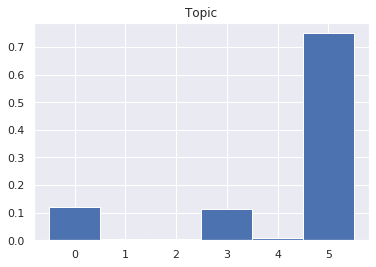

In [355]:
biden.hist(column='Topic',bins=6,range=(-0.5,5.5),density=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa003a79a50>]],
      dtype=object)

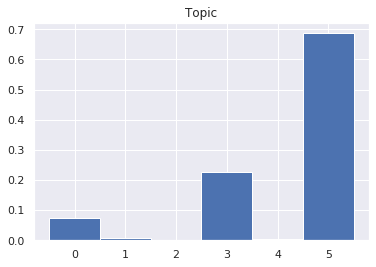

In [356]:
sanders.hist(column='Topic',bins=6,range=(-0.5,5.5),density=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa003ac1f90>]],
      dtype=object)

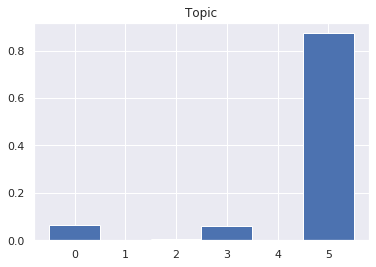

In [357]:
klobuchar.hist(column='Topic',bins=6,range=(-0.5,5.5),density=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa003972b10>]],
      dtype=object)

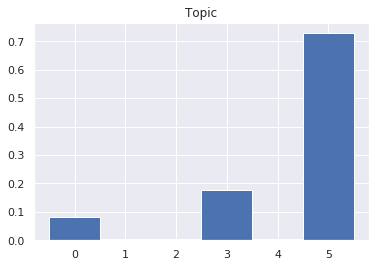

In [358]:
warren.hist(column='Topic',bins=6,range=(-0.5,5.5),density=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa0038a2790>]],
      dtype=object)

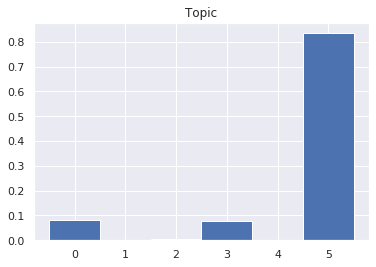

In [360]:
buttigieg.hist(column='Topic',bins=6,range=(-0.5,5.5),density=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa0038bc910>]],
      dtype=object)

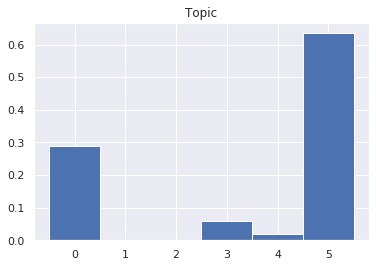

In [361]:
gabbard.hist(column='Topic',bins=6,range=(-0.5,5.5),density=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa0037df110>]],
      dtype=object)

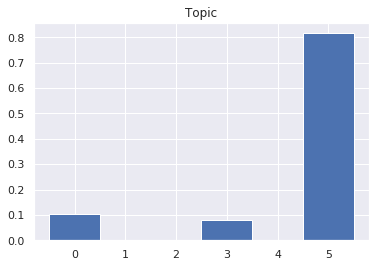

In [362]:
bloomberg.hist(column='Topic',bins=6,range=(-0.5,5.5),density=True)

It is clear that most candidates loop in discussion about the American people or the country. This makes sense. They are, after all, attempting to run to be president of the United States.

We can also see, that both Warren and Bernie spend a large portion of their responses talking about health care than the other candidates. Tulsi Gabbard's main focus appears to be guns.

### TO DOs

- Loop in time
- Finish explanation of LDA and the parameters

### Things that could be improved

I went into this project knowing virtually nothing about NLP, so I'm sure there's a lot which could be improved beyond what I list here.

- If I wanted to keep more of the data, I could potentially analyze the number of works spoken for those missing speaking_time entries and estimate how much times is taken up by those sections using the average words spoken.

- I removed short segments based on eye-balling the topics. I could have looked at the distribution of words for all time segments, after removing stop words, and see when words related to policy show up.

- Keep moderator questions. If I kept moderator questions, I could ask more questions about whether the candidate avoided the question.

- Allow for multiple topic statements.